In [2]:
import os
import sys
# Load the local code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.read_parallel import read_parallel_local
import pandas as pd

In [ ]:
#!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git /home/ubuntu/models
#! pip install tensorflow_hub
#! pip install tensorflow_datasets
#!pip install -Uqr /home/ubuntu/models/official/requirements.txt


In [3]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('/home/ubuntu/models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
REDUCE_BY_FACTOR = 20.0 # Make the dataset smaller for development purposes
train_test_ratio = 0.91
train_valid_ratio = 0.90
first_n_words = 512
destination_folder = 'bert_classification'

if 'DATA_VOL' not in os.environ:
    # Manually set:
    DATA_VOL = '/datavol'
else:
    DATA_VOL = os.environ['DATA_VOL']
    
# Pre-wrangled metadata
df = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df.id = df.id.astype(int)    
print(f"Original number of examples: {len(df)}")
df = df.sample(n=int(len(df)/REDUCE_BY_FACTOR)) #
print(f"Reduced number of examples:  {len(df)}")

tmp = read_parallel_local(df['id'], DATA_VOL + "/clean/")
df['text'] = tmp
df = df.reset_index(drop=True)

Original number of examples: 118815
Reduced number of examples:  5940
Took 0.028833107153574625 min to open 5940 files with 20 processes.


In [35]:
#import pandas as pd
#df = pd.read_csv("../references/derived/ml_data.csv", encoding="latin1", parse_dates=True)
df.tail()

,id,version_number,bill_id,signed,partisan_lean,sc_id,text
5935,2144866,1,1112117,0,0.230769,567-2,1 state of oklahoma 1st session of the 57th le...
5936,2263264,3,1176266,1,0.410000,570-1,66th legislature hb0543.01 house bill no. intr...
5937,2267856,4,1126550,1,0.895330,611-1,"the senate thirtieth legislature, state of ha..."
5938,2277409,1,1198350,0,0.399576,581-1,senate file introduced senate file by hogg a b...
5939,2239559,2,1177766,0,0.399576,581-1,senate study bill introduced senate file by ...


In [36]:
def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x
    
for i in range(len(df)):
    df.at[i, 'text'] = trim_string(df.at[i, 'text'])

In [37]:
# Train-test split
df_train_full, df_test = train_test_split(df, train_size = train_test_ratio, random_state = 1, stratify = df.signed.values)
# Train-valid split
df_train, df_valid = train_test_split(df_train_full, train_size = train_valid_ratio, random_state = 1, stratify = df_train_full.signed.values)

In [38]:
print(f"Training size: {df_train.shape}")
print(f"Validation size: {df_valid.shape}")
print(f"Test size: {df_test.shape}")

Training size: (4864, 7)
Validation size: (541, 7)
Test size: (535, 7)


In [39]:
!nvidia-smi

Sun Feb 28 19:46:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   45C    P0    70W / 149W |  10810MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
import tensorflow as tf
print(tf.version.VERSION)

2.4.1


In [41]:
#!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

In [42]:
#!pip install -Uqr models/official/requirements.txt
#f.device()

In [43]:
train_data1 = tf.data.Dataset.from_tensor_slices((df_train['text'].values, df_train['signed'].values))
val_data1 = tf.data.Dataset.from_tensor_slices((df_valid['text'].values, df_valid['signed'].values))
test_data1 = tf.data.Dataset.from_tensor_slices((df_test['text'].values, df_test['signed'].values))

In [44]:
for text, label in train_data1.take(1):
    print(text)
    print(label)

tf.Tensor(b'printer\'s no. the general assembly of pennsylvania senate bill no. session of introduced by hughes, fontana, brewster, schwank, costa and farnese, february 2019 referred to education, february 2019 an act amending the act of march 1949 entitled "an act relating to the public school system, including certain provisions applicable as well to private and parochial schools; amending, revising, consolidating and changing the laws relating thereto," establishing the health-related industries educational scholarship program and the healthrelated industries educational scholarship program fund. the general assembly of the commonwealth of pennsylvania hereby enacts as follows: the act of march 1949 known as the public school code of is amended by adding an article to read: article xxvi-j health-related industries educational scholarship program -j. definitions. the following words and phrases when used in this article shall have the meanings given to them in this section unless the

In [45]:
train_batch_size = 32

In [46]:
max_seq_length = 128  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])



In [47]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
label_list = [0,1]

In [48]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  
    example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
    
    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)



In [49]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, [text, label],
                                                                   Tout = [tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])
    
    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    
    return (x, label_id)
    
    

In [50]:
with tf.device('/cpu:0'):
    train_data = (train_data1.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
             
             .shuffle(1000)
             .batch(train_batch_size, drop_remainder=True)
             .prefetch(tf.data.experimental.AUTOTUNE) 
             )

    val_data = (val_data1.map(to_feature_map, num_parallel_calls=tf.data.experimental.AUTOTUNE)
             .batch(train_batch_size, drop_remainder=True)
             .prefetch(tf.data.experimental.AUTOTUNE) 
            )

In [51]:
val_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [61]:
def create_model_basic():
        input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
        input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
        input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")
        pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
        drop = tf.keras.layers.Dropout(0.4)(pooled_output)
        output = tf.keras.layers.Dense(1, activation='sigmoid')(drop)
        
        model = tf.keras.Model(
          inputs={
              'input_word_ids': input_word_ids,
              'input_mask': input_mask,
              'input_type_ids': input_type_ids
          },
          outputs=output
        )
        return model

In [53]:
model = create_model_basic()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [54]:
#import pydot
#tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [55]:
epochs = 4
history = model.fit(train_data,
                   validation_data=val_data,
                   epochs=epochs,
                   verbose=1)

Epoch 1/4
152/152 [==============================] - 284s 2s/step - loss: 0.6098 - binary_accuracy: 0.7123 - val_loss: 0.4674 - val_binary_accuracy: 0.7754
Epoch 2/4
152/152 [==============================] - 261s 2s/step - loss: 0.4720 - binary_accuracy: 0.7674 - val_loss: 0.3965 - val_binary_accuracy: 0.8281
Epoch 3/4
152/152 [==============================] - 261s 2s/step - loss: 0.4185 - binary_accuracy: 0.7947 - val_loss: 0.3856 - val_binary_accuracy: 0.8223
Epoch 4/4
152/152 [==============================] - 261s 2s/step - loss: 0.3942 - binary_accuracy: 0.8116 - val_loss: 0.3759 - val_binary_accuracy: 0.8281


In [56]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

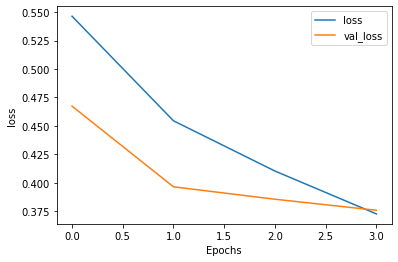

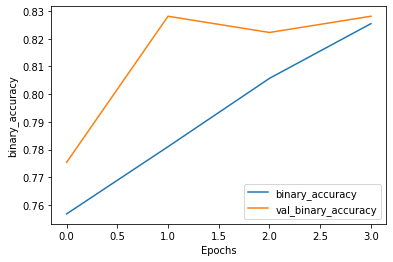

In [57]:
plot_graphs(history, 'loss')
plot_graphs(history, 'binary_accuracy')

In [58]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [59]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [60]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]